# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [3]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-04-02 18:32:35--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  13.5MB/s    in 13s     

2021-04-02 18:32:48 (13.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-04-02 18:32:48--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  9.85MB/s    in 5.4s    

2021-04-02 18:32:53 (11.4 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-04-02 18:32:53--
Total wall clock time: 19s
Downloaded: 2 files, 235M in

In [4]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [5]:
device = torch.device("cuda:0")

# Загружаем данные

In [6]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [7]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [8]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [9]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [11]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None): 
    if scheduler is not None:
        scheduler.step()   
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct, all_ = 0, 0
    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        scores = model(x_gpu)
        _, preds = scores.max(1)
        correct += (preds == y_gpu).sum()
        all_ += preds.size(0)
    
    model.train()
    
    return correct/all_

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.694249, Train accuracy: 0.789390, Val accuracy: 0.784793
Average loss: 0.596174, Train accuracy: 0.821964, Val accuracy: 0.826360
Average loss: 0.550152, Train accuracy: 0.834027, Val accuracy: 0.821992
Average loss: 0.515509, Train accuracy: 0.846159, Val accuracy: 0.829568
Average loss: 0.492957, Train accuracy: 0.852660, Val accuracy: 0.827657


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [14]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


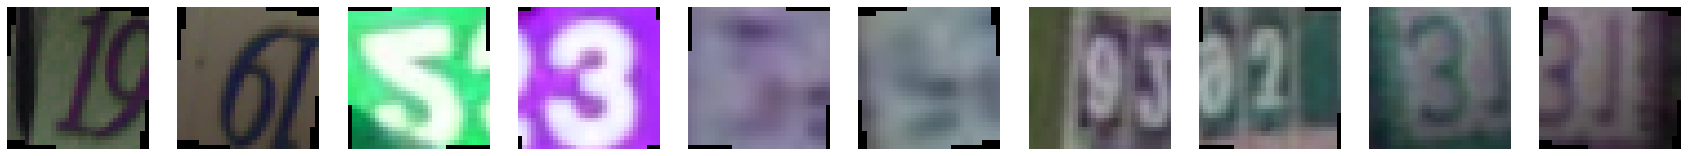

In [15]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

**в нашем случае полезны не все, потому что перевернутые и отзеркаленные цифры перестают иметь смысл**

Выберите из них только корректные

In [16]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.60),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(25, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_aug_loader = torch.utils.data.DataLoader(data_aug_vis, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler) 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [17]:
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.947774, Train accuracy: 0.699962, Val accuracy: 0.795577
Average loss: 0.816919, Train accuracy: 0.742262, Val accuracy: 0.824654
Average loss: 0.779292, Train accuracy: 0.753984, Val accuracy: 0.814825
Average loss: 0.756206, Train accuracy: 0.762550, Val accuracy: 0.792096
Average loss: 0.736131, Train accuracy: 0.768880, Val accuracy: 0.777490


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [18]:
lenet_model = nn.Sequential(
              nn.Conv2d(3, 6, 5, stride=1),
              nn.Tanh(),
              nn.AvgPool2d(2),
              nn.Conv2d(6, 16, 5, stride=1),
              nn.Tanh(),
              nn.AvgPool2d(2),
              nn.Conv2d(16, 120, 5, stride=1),
              nn.Tanh(),    
              Flattener(),
              nn.Linear(120, 84),
              nn.Tanh(),
              nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [19]:
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 2.225690, Train accuracy: 0.204194, Val accuracy: 0.272268
Average loss: 1.544991, Train accuracy: 0.486367, Val accuracy: 0.754556
Average loss: 0.913682, Train accuracy: 0.708699, Val accuracy: 0.782745
Average loss: 0.761892, Train accuracy: 0.759905, Val accuracy: 0.829363
Average loss: 0.683378, Train accuracy: 0.786489, Val accuracy: 0.845744
Average loss: 0.629501, Train accuracy: 0.802136, Val accuracy: 0.836666
Average loss: 0.595125, Train accuracy: 0.814268, Val accuracy: 0.857962
Average loss: 0.572259, Train accuracy: 0.820291, Val accuracy: 0.864583
Average loss: 0.547501, Train accuracy: 0.827970, Val accuracy: 0.873592
Average loss: 0.534966, Train accuracy: 0.831229, Val accuracy: 0.848884


# Подбор гиперпараметров

In [ ]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10
run_record = {} 

from random import choice
for _ in range(20):
    Hyperparams.learning_rate = choice(learning_rates)
    Hyperparams.anneal_epochs = choice(anneal_epochs)
    Hyperparams.reg = choice(reg)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=Hyperparams.learning_rate, weight_decay=Hyperparams.reg)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=Hyperparams.anneal_epochs, gamma=0.2)
    RunResult.model = lenet_model
    _, RunResult.train_history, RunResult.val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 5, scheduler=exp_lr_scheduler)
    RunResult.final_val_accuracy = RunResult.val_history[-1]
    if RunResult.val_history[4] - RunResult.val_history[0] > 3.: # нас интересует только те, которые обучились
        run_record[Hyperparams] = RunResult
    print()


In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [57]:
lenet_model = nn.Sequential(
              nn.Conv2d(3, 25, 3, padding=1),
              nn.BatchNorm2d(25),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(4),
              nn.Conv2d(25, 45, 3, padding=1),
              nn.BatchNorm2d(45),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(4),  
              nn.Conv2d(45, 57, 3, padding=1),
              # nn.BatchNorm2d(57),
              # nn.ReLU(inplace=True),
              Flattener(),
              nn.Linear(57*2*2, 150),
              nn.BatchNorm1d(150),
              nn.ReLU(inplace=True),
              nn.Linear(150, 10),
            )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.523922, Train accuracy: 0.475276, Val accuracy: 0.688485
Average loss: 0.914843, Train accuracy: 0.702249, Val accuracy: 0.745069
Average loss: 0.792651, Train accuracy: 0.744565, Val accuracy: 0.769982
Average loss: 0.722962, Train accuracy: 0.770331, Val accuracy: 0.796191
Average loss: 0.684647, Train accuracy: 0.781934, Val accuracy: 0.802880
Average loss: 0.655020, Train accuracy: 0.791387, Val accuracy: 0.824176
Average loss: 0.631469, Train accuracy: 0.800089, Val accuracy: 0.808750
Average loss: 0.604391, Train accuracy: 0.809610, Val accuracy: 0.826496
Average loss: 0.591260, Train accuracy: 0.812511, Val accuracy: 0.836052
Average loss: 0.582955, Train accuracy: 0.817630, Val accuracy: 0.816941


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [59]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)
final_test_accuracy = compute_accuracy(lenet_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  tensor(0.8387, device='cuda:0')
